# Analytic Inverse Kinematics of the leg in the plane

The goal of today's laboratory is to work out the analytic inverse kinematics of the leg (in 2D). The inverse kinematics problem is the problem of find joint angles that would lead to a desired end-effector position (as opposed to the forward kinematics problem where we find end-effector positions given joint angles).

## Instructions
Answer all the questions below and submit a pdf with detailed answers to these questions, including the plots through Brightspace. You will also need to submit the Jupyter notebooks with the code used to answer the questions.


## Robot model
Consider the following kinematic model of the robot <img src="./3d_robot_model.png" width="700">

## Forward kinematics solution

In the last laboratory we computed the forward kinematics of the robot. In the last laboratory we wrote the forward kinematics of the robot as a succession of primitive transformations. The resulting analytic formula can be computed easily for this robot. It is
$$ T_{SF} = \begin{bmatrix} \cos(\theta_1+\theta_2) & -\sin(\theta_1+\theta_2) & 0 & l_0 + l_1\sin\theta_1 + l_2 \sin(\theta_1 + \theta_2) \\ \cos\theta_0 \sin(\theta_1 + \theta_2) & \cos\theta_0 \cos(\theta_1 + \theta_2) & \sin\theta_0 & -\cos\theta_0 (l_1 \cos\theta_1 + l_2 \cos(\theta_1 + \theta_2)) - l_3\sin\theta_0 \\ \sin\theta_0 \sin(\theta_1 + \theta_2) & \sin\theta_0 \cos(\theta_1 + \theta_2) & \cos\theta_0 & -\sin\theta_0 (l_1 \cos\theta_1 + l_2 \cos(\theta_1 + \theta_2)) + l_3\cos\theta_0 \\ 0 & 0 & 0 & 1 \end{bmatrix} $$


## Position of the end-effector

The position of the end-effector (in the S frame) is therefore
$$ p_{SF} = \begin{pmatrix} l_0 + l_1\sin\theta_1 + l_2 \sin(\theta_1 + \theta_2) \\ -\cos\theta_0 \left(l_1 \cos\theta_1 + l_2 \cos(\theta_1 + \theta_2)\right) - l_3\sin\theta_0 \\ -\sin\theta_0 \left(l_1 \cos\theta_1 + l_2 \cos(\theta_1 + \theta_2)\right) + l_3\cos\theta_0 \end{pmatrix}$$

## Inverse kinematics problem

The inverse kinematics problem is the following: given a desired $p_{SF} = (x_{des},y_{des}, z_{des})$ position for the foot, can we find configurations $\theta_0$, $\theta_1$ and $\theta_2$ that would attain this position (if they exist)? The goal of an analytic inverse kinematics algorithm is to find all (if any) possible solutions to this problem in closed form. (we will see in later labs how to solve the problem with an iterative algorithm without computing the exact formulae).

## Question 1: analyzing possible solutions
1. In order to keep the problem "simple" we will constrain the solutions to be such that $\theta_0 = 0$. What does this imply for the possible values of $p_{SF}$? (i.e. what is the range of $x_{des}$, $y_{des}$ and $z_{des}$ for which the inverse kinematics problem will have a solution? You can describe the range of solutions geometrically.
2. Assume that the distance between the frame {H2} and the foot {F} is noted $l_{des} = \sqrt{(x_{des} - l_0)^2 + y_{des}^2}$, what is the largest value that $l_{des}$ can have? How many solutions to the inverse kinematics problem will there be when $l_{des}$ reaches its maximum? (describe them qualitatively)
4. If $l_{des}$ is now smaller than its possible largest value, how many solutions to the inverse kinematics problem will there be? (describe them qualitatively)

## Computing the analytic inverse kinematics
We need to find a way to relate the angles to the position of the leg. In our case, we will consider the influence of the joint angles on the leg length and then on its overall orientation.

Consider the triangle formed by $l_{des}$, $l_1$ and $l_2$. Using the [law of cosines](https://en.wikipedia.org/wiki/Law_of_cosines) we have the relation
$$l_{des}^2 - l_1^2 - l_2^2 = -2l_1 l_2 \cos(\pi - \theta_2)$$
which gives
$$\cos(\theta_2) = \frac{l_{des}^2 - l_1^2 - l_2^2}{2l_1 l_2}$$

we have then two possible choice for $\theta_2 = \pm \arccos(\frac{l_{des}^2 - l_1^2 - l_2^2}{2l_1 l_2})$. We will denote $\theta_2^+$ the positive solution (when the leg is bent with the knee pointing left) and $\theta_2^-$ the other solution (with the knee pointing toward the right).

We have seen that $\theta_2$ defines the distance from {H2} to {F}. $\theta_1$ will then define the position of the foot on the circle defined by the leg length. First we define some helpful quantities.
The angle between the line going from ${H2}$ to ${F}$ and the horizontal line going from ${H}$ to the right direction is $$\beta = \arctan2(y_{des}, x_{des} - l_0)$$
and the angle between $l_1$ and the {H2}-{F} line is (using again the law of cosines)
$$\alpha = \arccos(\frac{-l_2^2 + l_1^2 + l_{des}^2}{2l_1l_{des}})$$

We need to consider two distinct cases:

1. If we chose $\theta_2^+$: in this case, we have $\theta_1^+ = \pi/2 - \alpha + \beta$
2. If we chose $\theta_2^-$: in this case, we have $\theta_1^- = \pi/2 + \alpha + \beta$

## Question 2

1. Write an inverse kinematics function that takes a desired x,y position for the foot and returns a list of all possible solutions (if any) in terms of joint angles for $\theta_0$, $\theta_1$ and $\theta_2$.

2. Test you function using the ``test_IK function`` and the ``forward_kinematics`` function you implemented in the previous laboratory. ``test_IK function`` will generate a random desired (x,y) position for the foot, then compute the IK and verify that all the returned solutions are correct by computing the forward kinematics solution of each and verifying that ``forward_kinematics(inverse_kinematics(x, y)) = (x, y)``  

In [1]:
#setup nice plotting
%matplotlib notebook

# we import useful libraries
import time
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt

# we import the helper class / we will use a similar class to work with the real robot
use_real_robot = False

if use_real_robot:
    from nyu_finger import NYUFingerReal    
else:
    from nyu_finger_simulator import NYUFingerSimulator

pybullet build time: Jan 31 2022 13:10:48


In [2]:
# here we define the global variables for the robot size
l0 = 0.3
l1 = 0.16
l2 = 0.16
l3 = 0.014

In [3]:
def inverse_kinematics(x,y):
    """
    inverse kinematics function
    input (x,y) position of the foot
    output a list of 3D vectors which are possible solutions to the problem 
    (the list is empty if there are no solutions)
    """
    # TO BE COMPLETED
    return []

In [4]:
def test_IK(num_tests = 10):
    """
    This function is used to test the inverse kinematics function
    it generates num_tests random (x,y) locations and try to solve them
    it prints potential errors
    """
    num_errors = 0
    num_infeasible = 0
    points = np.zeros([num_tests, 2])
    colors = np.zeros([num_tests, 1])
    
    for i in range(num_tests):
        # we generate a random (x,y) location in a box of l1+l2 around {H}
        x = np.random.random_sample()*(l1+l2)*2 - (l1+l2) + l0
        y = np.random.random_sample()*(l1+l2)*2 - (l1+l2)

        # we save the point for plotting
        points[i,0] = x
        points[i,1] = y
        
        solutions = inverse_kinematics(x,y)
        
        l_des = np.sqrt((x-l0)**2 + y**2)
        if l_des > l1+l2:
            num_infeasible += 1
            colors[i] = 1
            
        if not solutions:
            # we did not find solutions
            # check if this is correct
            if l_des <= l1+l2:
                print(f'ERROR: IK did not find a solution while there should be at least one, for x={x} and y={y}')
                num_errors +=1
        else:
            for sol in solutions:
                pose = forward_kinematics(sol)
                x_ik = pose[0,3]
                y_ik = pose[1,3]
                error = np.sqrt((x-x_ik)**2 + (y-y_ik)**2)
                if error > 0.001:
                    print(f'solution {sol} did not find the correct IK solution x_des = {x}, y_des = {y} but found x_ik = {x_ik} and y_ik = {y_ik}')        
                    num_errors +=1
                    
    print(f'there were {num_tests-num_infeasible} feasible samples and {num_infeasible} infeasible ones')
    if num_errors > 0:
        print(f'there were {num_errors} errors detected')
    else:
        print('CONGRATS: no errors were detected!')
        
test_IK(10000)

ERROR: IK did not find a solution while there should be at least one, for x=0.21586369018526375 and y=0.04962811647777221
ERROR: IK did not find a solution while there should be at least one, for x=0.5219140192847277 and y=-0.004979547369681259
ERROR: IK did not find a solution while there should be at least one, for x=0.11956393033234958 and y=0.05161380759632073
ERROR: IK did not find a solution while there should be at least one, for x=0.512879353009021 and y=-0.01188423030346697
ERROR: IK did not find a solution while there should be at least one, for x=-0.017714507610651187 and y=-0.02323686616463283
ERROR: IK did not find a solution while there should be at least one, for x=0.5429093125089548 and y=-0.1411093127372076
ERROR: IK did not find a solution while there should be at least one, for x=0.005607165642500578 and y=0.0037371421619007417
ERROR: IK did not find a solution while there should be at least one, for x=0.1498925943258588 and y=0.03221856236680354
ERROR: IK did not fi

ERROR: IK did not find a solution while there should be at least one, for x=0.5045597739409596 and y=-0.2406309264682585
ERROR: IK did not find a solution while there should be at least one, for x=0.6080518758666876 and y=-0.0017348780490217819
ERROR: IK did not find a solution while there should be at least one, for x=0.3667143619049809 and y=0.2160246840908055
ERROR: IK did not find a solution while there should be at least one, for x=0.2528266705276473 and y=-0.22406823448847724
ERROR: IK did not find a solution while there should be at least one, for x=0.504139544266915 and y=0.12703654117034874
ERROR: IK did not find a solution while there should be at least one, for x=0.20714994848119245 and y=0.029327537811290383
ERROR: IK did not find a solution while there should be at least one, for x=0.4189870406597789 and y=0.15952655951832978
ERROR: IK did not find a solution while there should be at least one, for x=0.15461760848473644 and y=0.1266660561479449
ERROR: IK did not find a sol

ERROR: IK did not find a solution while there should be at least one, for x=0.3903073060047953 and y=-0.139987051806406
ERROR: IK did not find a solution while there should be at least one, for x=0.46036493652044996 and y=0.09963537507791709
ERROR: IK did not find a solution while there should be at least one, for x=0.30826701189185896 and y=-0.036980312888495126
ERROR: IK did not find a solution while there should be at least one, for x=0.25626789566113023 and y=-0.05065497516155498
ERROR: IK did not find a solution while there should be at least one, for x=0.43280027525040565 and y=0.13561607307197726
ERROR: IK did not find a solution while there should be at least one, for x=0.4606583608023565 and y=-0.23968511851378793
ERROR: IK did not find a solution while there should be at least one, for x=0.2257509565897398 and y=-0.19209735058620986
ERROR: IK did not find a solution while there should be at least one, for x=0.07665925215576497 and y=0.11435889183672449
ERROR: IK did not find 

# A reaching controller

# Question:
The code below generates 3 target ball locations (and display them). Their locations are in the variable ball_position (a list containing 2D vectors of x,y positions).

1. Modify the code below (our typical control loop with a PD controller) such that the robot moves from its current position to each ball successively. Use the inverse kinematics function to decide what the end joint angles should be. Interpolate the motion to the desired goal such that the total time for one reaching movement is T=2 seconds (i.e. go from initial configuration to ball1 in 2 seconds, from ball1 to ball2 in 2 seconds, etc).

2. Use the plotting function below to plot the motion of the foot in space and the joint position/velocity trajectories. How well does it go through the targets?

3. Answer question 2. with the real robot

In [5]:
if use_real_robot:
    # Triggers the real robot
    # Don't forget to turn on the robot first !!!
    robot = NYUFingerReal()
    # Make sure that the motor number matches that on the robot
    motor_number = np.array([1,2,3])
    robot.initialize('ens1', motor_number)
else:
    # we can now create a robot simulation
    robot = NYUFingerSimulator()

# we reset the simulation
if not use_real_robot:
    robot.reset_state([0,0,0])

    
# we simulate for 6 seconds (2 seconds per goal)
run_time = 6.
dt = 0.001
num_steps = int(run_time/dt)

# the PD gains
P = np.array([1.5, 1.5, 1.5])
D = np.array([0.01, 0.01, 0.01])

# we store information
measured_positions = np.zeros([num_steps,3])
measured_velocities = np.zeros_like(measured_positions)
desired_torques = np.zeros_like(measured_positions)
desired_positions = np.zeros_like(measured_positions)
desired_velocities = np.zeros_like(measured_positions)
time = np.zeros([num_steps])

measured_foot_position = np.zeros([num_steps,3])
desired_foot_position = np.zeros([num_steps,3])

# here we create a list of ball positions and display them
ball_positions = [np.array([0.597,-0.056]), np.array([0.521,0.12]), np.array([0.3,-0.225])]
for ball in ball_positions:
    robot.add_ball(ball[0], ball[1])  

# the time to reach a goal
time_to_goal = 2.0

# we use this to know which target we are currently aiming
ball_number = 0

# we measure the internal time for one target movement
t = 0.

for i in range(num_steps):
    # get the current time and save it
    time[i] = dt * i
    
    # we get the position and velocities of the joints
    q, dq = robot.get_state()
    measured_positions[i,:] = q
    measured_velocities[i,:] = dq
    
    # save the current position of the foot using the FK function
    pose = forward_kinematics(q)
    measured_foot_position[i,:] = pose[0:3,3]
    
    # controller: TODO HERE IMPLEMENT YOUR CONTROLLER TO REACH ALL 3 TARGETS
    # compute the desired position and velocities for each joint separately using the compute_trajectory function
    # the goal here is to compute q_des and dq_des that the PD controller will follow
    # you will need some internal logic to decide which ball you are currently targetting, etc.

    # change this according to your needs so the robot moves according to your goals
    q_des = np.array([0, 0, 0])
    dq_des = np.array([0, 0, 0])
    
    
    # we save the desired positions/velocities for later plotting 
    desired_positions[i,:] = q_des
    desired_velocities[i,:] = dq_des
    
    ##PD controller
    error = q_des - q # the position error for all the joints (it's a 3D vector)
    d_error = dq_des-dq # the velocity error for all the joints
    
    # we compute the desired torques as a PD controller
    joint_torques = P * error + D * d_error
    desired_torques[i,:] = joint_torques
    
    # we send them to the robot and do one simulation step
    robot.send_joint_torque(joint_torques)
    robot.step()

2022-02-28 16:49:58.277 Python[22737:1794598] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/5r/vbxm70j97n13xz8b5hp6stxw0000gn/T/org.python.python.savedState


<IPython.core.display.Javascript object>


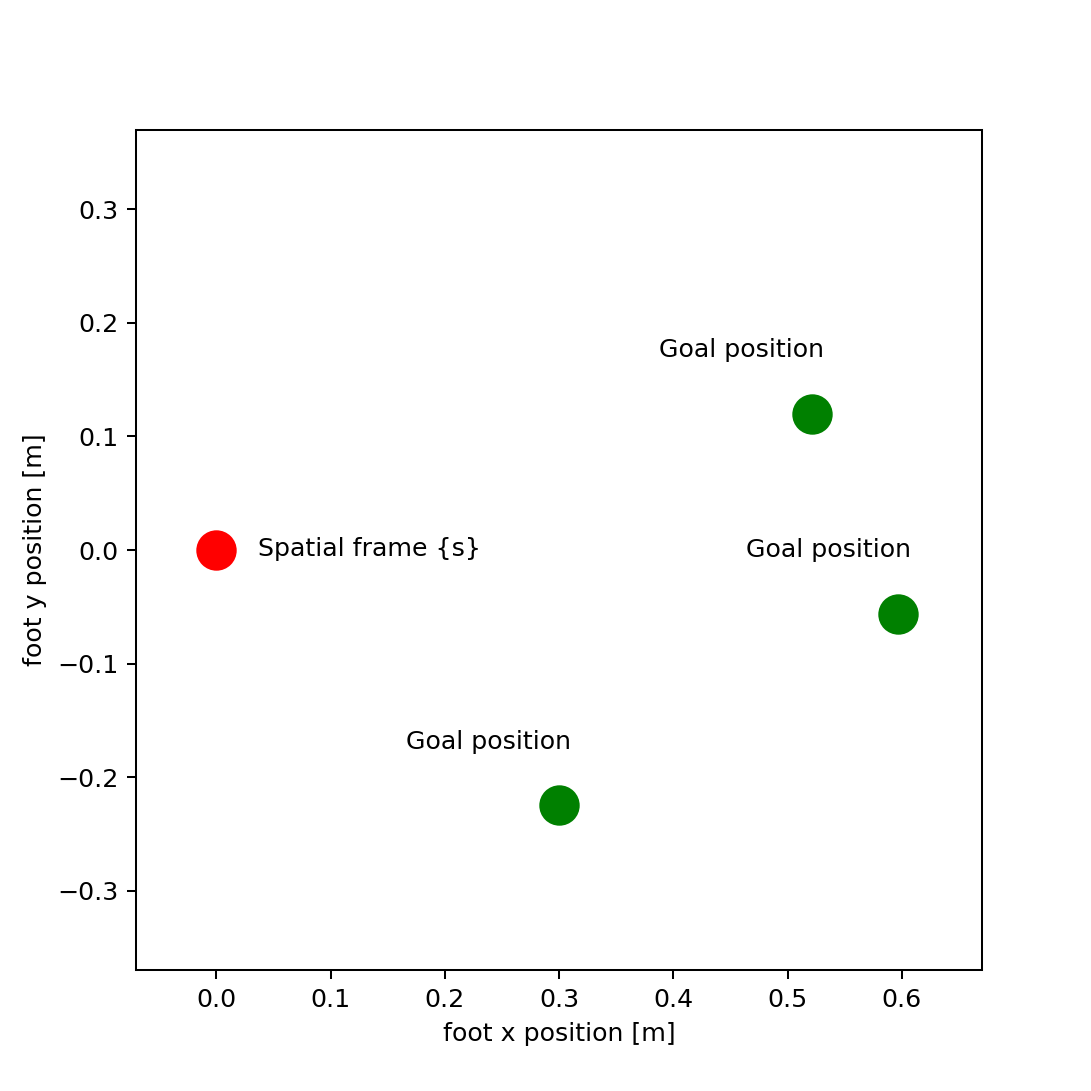

In [6]:
def plot_foot_trajectory(foot_position, ball_positions):
    """
    plots the position of the foot in 2D and the position of the spatial frame {s}
    we assume that the time varying x variable is in x_pos and that the y variable is in y_pos
    """
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    plt.plot(foot_position[:,0],foot_position[:,1], 'b')
    plt.xlabel('foot x position [m]')
    plt.ylabel('foot y position [m]')
    plt.xlim([-l1-l2+l0-0.05,l0+l1+l2+0.05])
    plt.ylim([-l1-l2-0.05, l1+l2+0.05])
    plt.plot([0],[0],'o',markersize=15,color='r')
    
    for ball in ball_positions:
        plt.plot([ball[0]],[ball[1]],'o',markersize=15,color='g')
        ax.annotate('Goal position', xy=(ball[0]-0.2,0.05+ball[1]), xytext=(30,0), textcoords='offset points')
    ax.annotate('Spatial frame {s}', xy=(-0.03,-0.005), xytext=(30,0), textcoords='offset points')
    

plot_foot_trajectory(measured_foot_position, ball_positions)

<IPython.core.display.Javascript object>


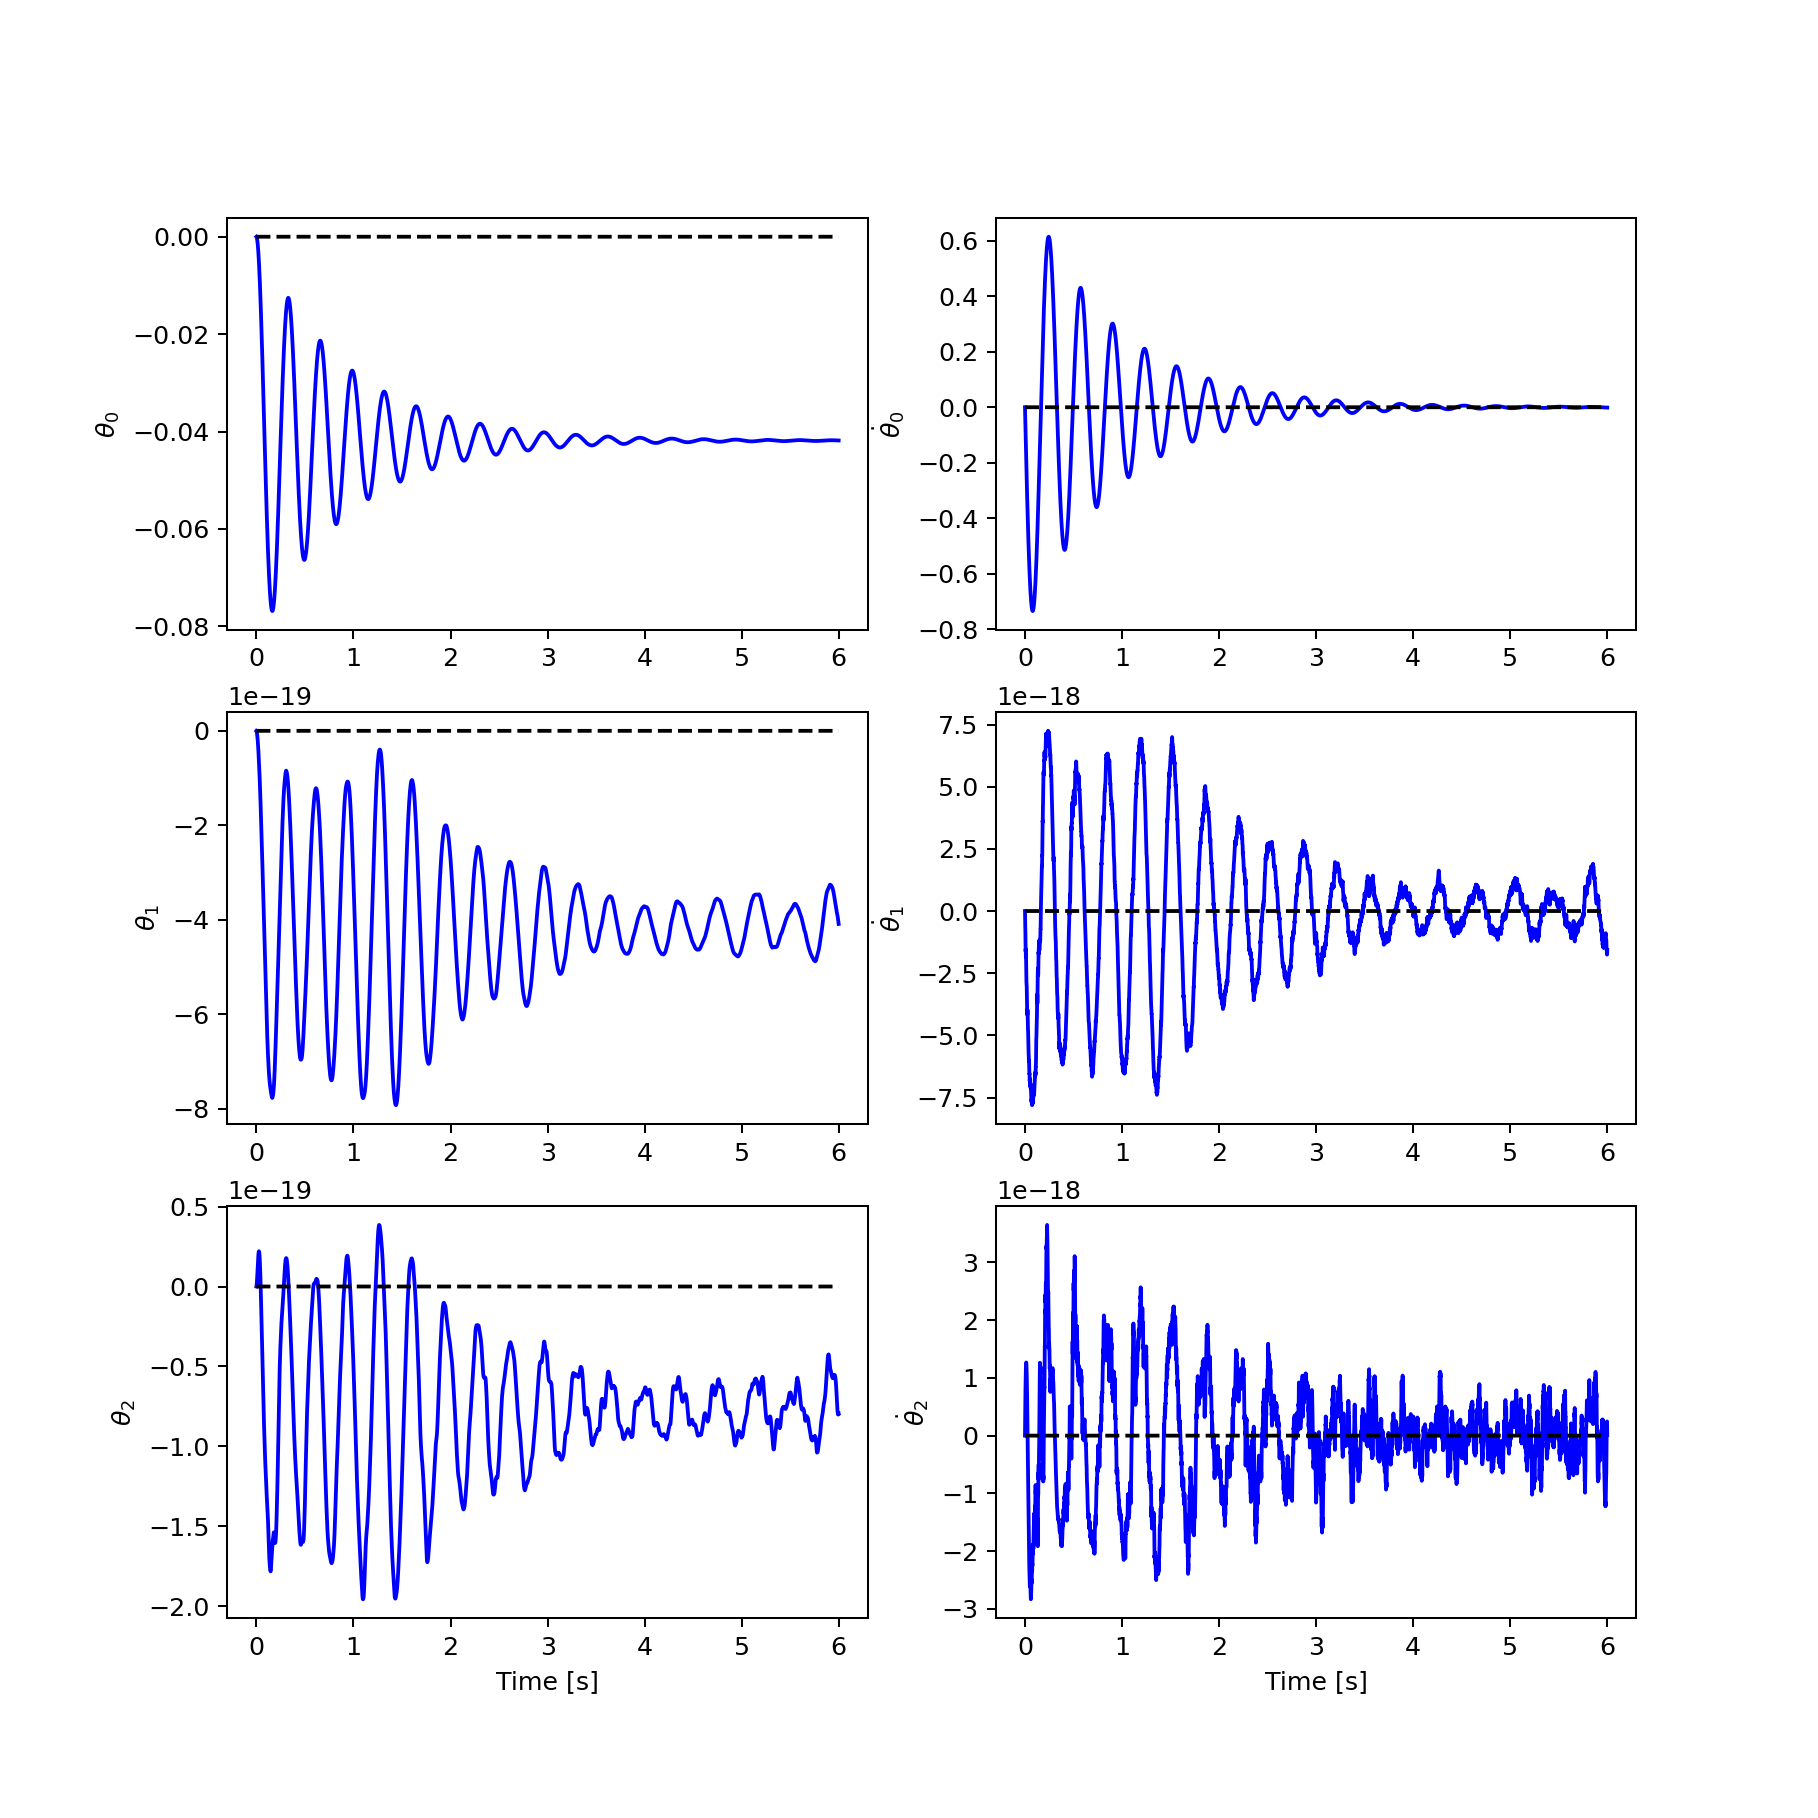

In [17]:
def plot_joint_posvel(time, th, th_des, dth, dth_des):
    fig = plt.figure(figsize=(10,10))
    
    plt.subplot(3,2,1)
    plt.plot(time, th[:,0], 'b-', time, th_des[:,1], '--k')
    plt.ylabel(r'$\theta_0$')
    plt.subplot(3,2,3)
    plt.plot(time, th[:,1], 'b-', time, th_des[:,1], '--k')
    plt.ylabel(r'$\theta_1$')
    plt.subplot(3,2,5)
    plt.plot(time, th[:,2], 'b-', time, th_des[:,2], '--k')
    plt.ylabel(r'$\theta_2$')
    plt.xlabel('Time [s]')
    
    plt.subplot(3,2,2)
    plt.plot(time, dth[:,0], 'b-', time, dth_des[:,1], '--k')
    plt.ylabel(r'$\dot{\theta}_0$')
    plt.subplot(3,2,4)
    plt.plot(time, dth[:,1], 'b-', time, dth_des[:,1], '--k')
    plt.ylabel(r'$\dot{\theta}_1$')
    plt.subplot(3,2,6)
    plt.plot(time, dth[:,2], 'b-', time, dth_des[:,2], '--k')
    plt.ylabel(r'$\dot{\theta}_2$')
    plt.xlabel('Time [s]')
    
plot_joint_posvel(time, measured_positions, desired_positions, measured_velocities, desired_velocities)